# Chapter 17: Calibrate HBV

[JP Gannon](https://jpgannon.github.io/)
[](https://orcid.org/0000-0002-4595-3214)
([Virginia Tech](https://www.vt.edu/))  
2026-01-14

# Intro to Modeling - Calibrate HBV

## Introduction

The following activity is available as a template github repository at
the following link:
<https://github.com/VT-Hydroinformatics/17-calibrate-model-for-loops>

*Goals for this activity:*

-   Learn how for loops work
-   Use for loops to calibrate the HBV model using the Monte Carlo
    technique
-   Assess the results of the calibration, discuss equifinality

We saw in the last activity that coming up with the parameters that
create a model that fits our watershed discharge best is hard. For this
reason, there are several ways people have devised for automating the
process. We are going to explore one: a Monte Carlo calibration.

To use this approach, we will create a ton of random parameter sets, run
the model for each, and then see which one fits best. The idea is that
by creating a bunch of random sets of parameters, we will end up with at
least one that works well. As you might guess, this can take a while. We
will just do this for 100 or 1000 runs here in this activity, but we
will also explore some output from a 100,000 run Monte Carlo that I ran
and saved.

There is one new package this time, GGally, just for creating a parallel
coordinate plot to look at the results of the 100k run Monte Carlo at
the end.

In [ ]:
library(tidyverse)
library(lubridate)
library(plotly)
library(GGally) #for making parallel coordinate plot

theme_set(theme_classic())

In order to do what we are going to do, we need “for” loops.

A for loop is a way to run a chunk of code several times while changing
a value in that chunk of code each time.

So using an example from class: you could run some code that downloads
data from a USGS gage, and each time through the loop it changes which
gage you download.

In R, the syntax for this is

> for(x in sequence){  
> x  
> }  

Where x will change every time you go through the loop. The values x
will have each time through the loop are those that are in “sequence”
above. If you changed this to x in 1:3, x would have values of 1, 2, and
3 each time through. If you made it x in c(2,3,5) x would change to 2,
then 3, and then 5 each time through the loop. You can make the sequence
anything and x can have any name so “letter in c(a, b, c)” would have
*letter* change to a, then b, then c each time through the loop.

The image below shows a short example of how a for loop works.

![](attachment:images/for%20loop.png "for loop")

*for loop*

Let’s try some examples
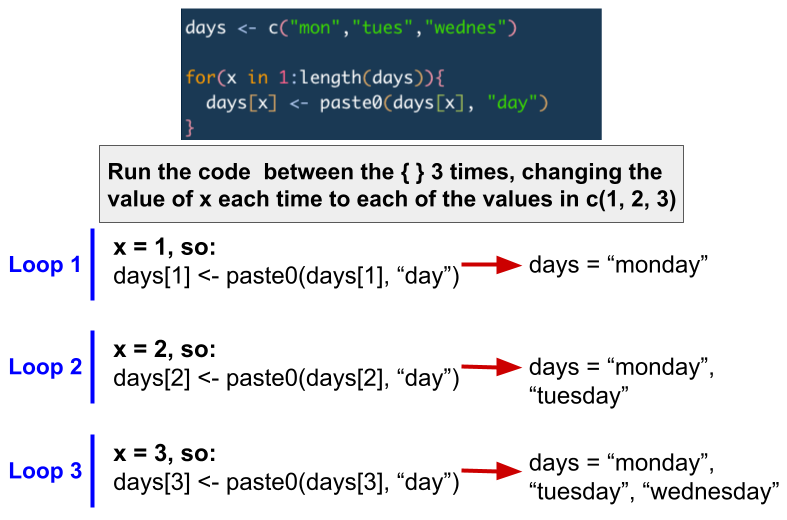

In [ ]:
val <- 0

for(x in 1:10){
  val[x] <- x
}

val

 [1]  1  2  3  4  5  6  7  8  9 10

[1] "monday"    "tuesday"   "wednesday"

[1] "123"
[1] "ABC"
[1] "001"

## Challenge: Write a for loop

Define a vector with values 5, 6, 7, 8, 9

Create a for loop that steps through this vector and adds 1 to each
value.

Yes, you can do this by just typing the name of the vector + 1, but
that’s not the point!

## Prep data for HBV

Since we did this in the last chapter, we are just going to quickly run
the code the preps our data to go into the model. Below we load the HBV
model and make vectors of P, Qobs, and Temp.

In [ ]:
#Create the HBV function with the HBV R file
source('HBV/HBV.R')

#set start and end dates for model to filter data
start <- mdy("01-01-2009")
end <- mdy("12-31-2012")

#Precip
P1 <- read_csv("HBV/Pwd2009-2012.csv") |> 
         select(DATE, WS_3) |>
         mutate(DATE = ymd(DATE)) |>
         filter(DATE >= start & DATE <= end)

Rows: 1461 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (10): DATE, WS_1, WS_2, WS_3, WS_4, WS_5, WS_6, WS_7, WS_8, WS_9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 1461 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (10): DATE, WS_1, WS_2, WS_3, WS_4, WS_5, WS_6, WS_7, WS_8, WS_9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 1461 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): DATE, STA_1, STA_6, STA_14, STA_INT, STA_HQ, STA_23, STA_17, STA_24

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

New names:
Rows: 76 Columns: 25
── Column specification
──────────────────────────────────────────────────────── Delimiter: "," chr
(1): DATE dbl (21): STA1, STA2, STA3, STA4, STA5, STA6, STA7, STA8, STA9,
STA10, STA11... lgl (3): ...23, ...24, ...25
ℹ Use `spec()` to retrieve the full column specification for this data. ℹ
Specify the column types or set `show_col_types = FALSE` to quiet this message.
• `` -> `...23`
• `` -> `...24`
• `` -> `...25`

ℹ In argument: `DATE = ymd(DATE)`.
Caused by warning:
!  8 failed to parse.

## Calculate PET

Again, because we did this last time, we will just re-run this code to
create our PET values.

In [ ]:
lat <- 43 + 57/60 #43 degrees and 57 minutes
latrad <- (lat/360) * 2 * pi #convert to radians

PET1 <- select(Temp1, DATE) |>
         mutate(DOY = yday(DATE)) |> #DOY for dates
         mutate(tempvar = (2 * pi / 365) * DOY) |>
         #declination of the sun above the celestial equator in 
         #radians on day JulDay of the year
         mutate(delta_h = 0.4093 * sin(tempvar - 1.405)) |> 
         #day length in h
         mutate(daylen = (2 * acos(-tan(delta_h) * tan(latrad)) / 0.2618)) |> 
         mutate(
           PET = 29.8 * daylen * 0.611 * exp(17.3 * Temp / 
                  (Temp + 237.3)) / (Temp + 273.2))  #PET Hamon method

PET <- PET1$PET

## Monte Carlo step 1: generate random parameter sets

Below is a table of the parameters for the HBV model and their suggested
min and max values for our application. What we basically want to do is
mimic you sitting down at the computer and randomly changing all the
parameters, running the model, and checking to see how well it did.
Over, and over, and over.

You can do this by generating the set of parameters each time you run
the model, but we are going to do it separately so we can see the
Nashe-Sutcliff efficiency (NSE) for each set of parameters.

| Object Name | Min   | Max  | Description                                                              |
|--------------|--------|-------|-------------------------------------------|
| FC          | 40    | 400  | Max soil moisture storage, field capacity                                |
| beta        | 1     | 6    | Shape coefficient governing fate of water input to soil moisture storage |
| LP          | .3    | 1    | Threshold for reduction of evaporation                                   |
| SFCF        | 0.4   | 1.2  | Snowfall correction factor                                               |
| TT          | -1.5  | 1.2  | Threshold temperature                                                    |
| CFMAX       | 1     | 8    | Degree-day factor                                                        |
| k0          | 0.05  | 0.5  | Recession constant (upper storage, near surface)                         |
| k1          | 0.01  | 0.3  | Recession constant (upper storage)                                       |
| k2          | 0.001 | 0.15 | Recession constant (lower storage)                                       |
| UZL         | 0     | 70   | Threshold for shallow storage                                            |
| PERC        | 0     | 4    | Percolation, max flow from upper to lower storage                        |
| MAXBAS      | 1     | 3    | base of the triangular routing function, days”                           |

To make our parameter sets, we first have to decide how many model runs
we want to try. Let’s try 100 so we don’t burn down anyone’s computer.

Then we will use the runif() function to generate the same number of
random values as the number of model runs we want to perform for each
parameter, within the bounds of the min and max values above.

Remember, runif() creates a set of random numbers in a uniform
distribution with a specified length with a specified minimum and
maximum value. A uniform distribution is one where each number has the
same probability of occurrence as the next, so it’s basically a set of
random numbers between your min and max values.

We will also create a blank vector of the same length which we will
populate with the NSE values for each model run, and then slap them all
together with cbind() (column bind).

In [ ]:
#number of runs
N <- 100

# PARAMETERS RANGE and generate set
FC    <- runif(N, min = 40   , max = 400)  #Max soil moisture storage, field capacity
beta  <- runif(N, min = 1    , max = 6)    #Shape coefficient governing fate of water input to soil moisture storage
LP    <- runif(N, min = 0.3   , max = 1)    #Threshold for reduction of evap
SFCF  <- runif(N, min = 0.4  , max = 1.2)  #Snowfall correction factor
TT    <- runif(N, min = -1.5 , max = 1.2)  #Threshold temperature
CFMAX <- runif(N, min = 1    , max = 8)    #Degree-day factor
k0    <- runif(N, min = 0.05 , max = 0.5)  #Recession constant (upper storage, near surface)
k1    <- runif(N, min = 0.01 , max = 0.3)  #Recession constant (upper storage)
k2    <- runif(N, min = 0.001, max = 0.15) #Recession constant (lower storage)
UZL   <- runif(N, min = 0    , max = 70)   #Threshold for shallow storage
PERC  <- runif(N, min = 0    , max = 4)    #Percolation, max flow from upper to lower storage
MAXBAS<- rep(1, N)   #base of the triangular routing function, days
#MAXBAS is just 1's because routing will be set to zero, so the parameter isn't used

NSE <- rep(NA, N) #create NSE column, to be filled in for loop

routing <- 0

pars <- cbind(FC, beta, LP, SFCF, 
               TT, CFMAX, k0, k1, 
               k2, UZL, PERC, MAXBAS, NSE) 

## Run the model for each parameter set

Alright, let’s get at this. We now have our random sets of parameters.
So we will run the model for each and see how it does.

Here’s how we will do that:

First: Define the period for which we want to calculate NSE. Remember we
are going to drop the first 40% of the model run to let the model “warm
up”. Since we are starting with nothing in the storages we need to let
the boxes “fill up” and settle in.

Then we run a FOR LOOP!

Our for loop will step through a sequence of numbers from 1 to the total
number of parameter sets we have. So in this case: 100. We will use i as
our variable. So i will be 1, 2, 3…. all the way to 100.

In the code portion of the loop, it will grab the parameters from row i
of the parameter set we created. And pass that to the HBV function with
the Precip, Temp, and PET data. Remember routing is just set to zero.

After we run the model (still in the for loop) we will stick our
observed values onto the results and then trip them to the period we
want to evaluate. (drop the first 40%)

Finally, we calculate NSE for that individual model run, and then add it
into the NSE column we made before. So each run will just tack on an NSE
value to the end of the parameter set. We don’t need to save the model
results, because we can just rerun the model with the same parameters
and it’ll give us the same output.

The figure below illustrates how the for loop will work:

![](attachment:images/monte%20carlo%20for%20loop.png "Monte Carlo for loop")

*Monte Carlo for loop*
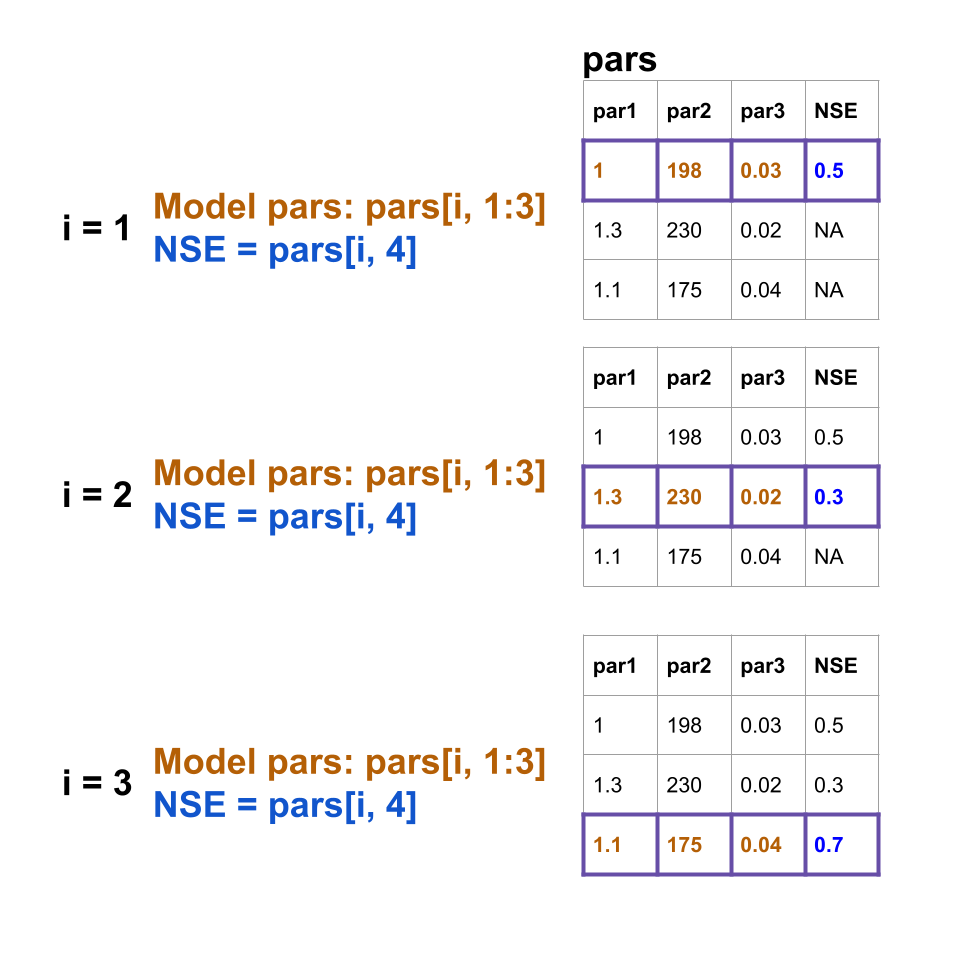

In [ ]:
#trim the first 40% (warm up) of Qobs off for NSE calculation 
EvalStart <- floor(length(Qobs) * 0.4)
EvalEnd <- length(Qobs)


for (i in 1:N){
   
   #call model with i parameter set generated above
   results <- HBV(pars[i,1:12], P, Temp, PET, routing)
   
   #add the Qobs to results
   results <- cbind(results, Qobs)
   
   #trim the first 40% of the record so it isn't included in the NSE calculation
   results <- results[EvalStart:EvalEnd,]
    
   #Calculate NSE and add to parameter set
   pars[i,13]  <- 1 - ((sum((results$Qobs - results$q) ^ 2)) / sum((results$Qobs - mean(results$Qobs)) ^ 2))
   
}

## Find the best parameter set

Alright, now we have a NSE value that tells us how well each parameter
set did at estimating runoff. So we need to find the best one!

To do this, we will convert the parameter sets to a tibble, use filter
to grab the row with the maximum NSE, then use slice to pull just that
row out of the tibble. Finally, we will run as.numeric on the data to be
sure everything is numbers.

Now we have our best parameter set, let’s see how it did!

We will do what we did in the previous lesson: run the model with the
parameter set, slap on the observed data, and filter it to the time
period we want to look at. (after 08-07-2010 in this case, that’s the
40% cutoff in this case)

In [ ]:
#find best parameters
pars <- as_tibble(pars)

bestparams <- pars |> filter(NSE == max(NSE)) |>
                        slice(1) |>
                        as.numeric()

#run with best parameters
modeloutput <-  HBV(bestparams, P, Temp, PET, routing)

#add observations for plotting
modeloutput <- bind_cols(modeloutput, Qobs1)

#trim out warm up period for plotting
OutputTrim <- filter(modeloutput, DATE >= mdy("08-07-2010"))

Below we will look at the model run using plotly. First, we calculate
the NSE again, just to be sure, and then plot the same way we did in the
last lesson.

How did the model do? Did the 100 run Monte Carlo do better or worse
than your manual attempts from last lesson?

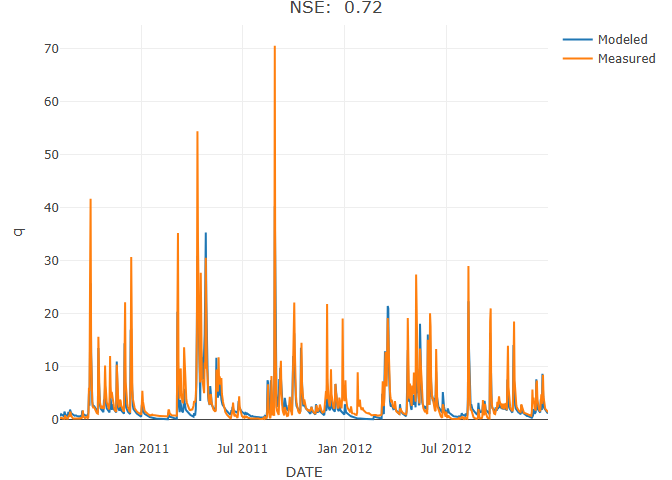

In [ ]:
#Calculate NSE
NSE <- 1 - ((sum((OutputTrim$q - OutputTrim$WS_3) ^ 2)) / 
                 sum((OutputTrim$WS_3 - mean(OutputTrim$WS_3)) ^ 2))

#Create plot with NSE in title
OutputTrim |> plot_ly(x = ~DATE) |> 
        add_trace(y = ~q, name = 'Modeled',  type = 'scatter', mode = 'lines') |> 
        add_trace(y = ~WS_3, name = 'Measured', type = 'scatter', mode = 'lines') |> 
        layout(title=paste("NSE: ", round(NSE,2)))

## Investigating a much bigger Monte Carlo

The next couple of code chunks make plots from a Monte Carlo I ran with
100,000 parameter sets.

We will look at the two plots and discuss.

How much difference was there in NSE in the top 100 runs of the 100,000
run set? How much would you expect the parameters to vary between these
runs? What do you think it means if they did or did not vary much?

New names:
Rows: 100 Columns: 15
── Column specification
──────────────────────────────────────────────────────── Delimiter: "," dbl
(15): ...1, FC, beta, LP, SFCF, TT, CFMAX, k0, k1, k2, UZL, PERC, MAXBAS...
ℹ Use `spec()` to retrieve the full column specification for this data. ℹ
Specify the column types or set `show_col_types = FALSE` to quiet this message.
• `` -> `...1`

`stat_bin()` using `bins = 30`. Pick better value `binwidth`.

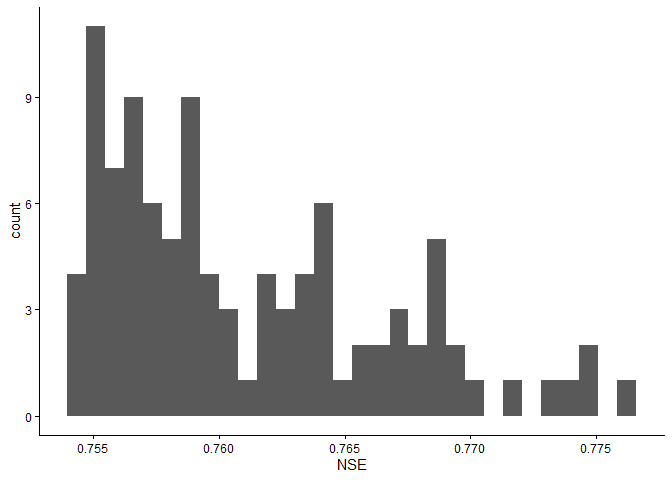

In [ ]:
#the [,-1] drops the first column, which is just row numbers
pars100 <- read_csv("HBV/parsFrom100kRun.csv")[,-1]

The chunk below creates a parallel coordinate plot. Each parameter is
shown, but normalized, where 1 is it’s maximum value from our random
sets, and 0 is the minimum value.

Each connected line is a set of parameters. The green line is the set
that had the highest NSE.

Look at this plot for a bit and discuss.

Are there any parameters that were always in the same range for these
runs? What does that tell you about them? Are there any parameters that
look like they spanned almost the whole range for these runs? What does
that tell you about them? What does this plot tell you about the model’s
representation of the real world?

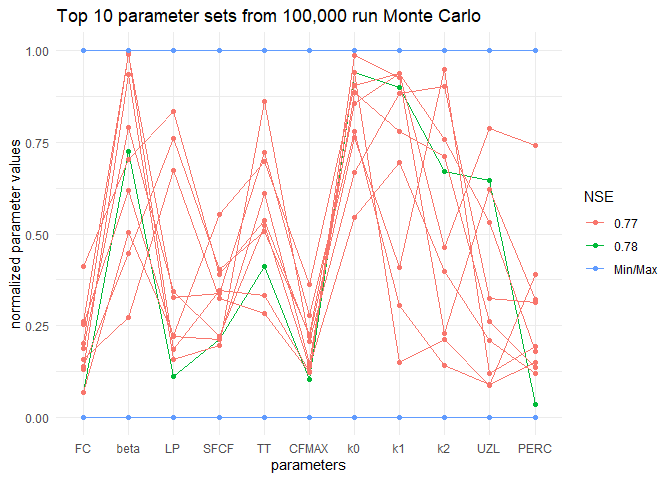

In [ ]:
#filter the 100,000 run to the top ten
rankedpars <- filter(pars100, ranks <= 10)

#set the min and max values for each parameter for the plot
mins <- c(40, 1, 0.3 , 0.4, -1.5, 1, 0.05, 0.01, 0.001, 0, 0, 1, 0, 0)
maxs <- c(400, 6, 1, 1.2, 1.2, 8, 0.5, 0.3, 0.15, 70 , 4, 3, 0, 0)

#add maxes and mins to the parameter sets
rankedpars <- rbind(rankedpars, mins, maxs)

#Make NSE a character so the legend will work properly
rankedpars <- rankedpars |> mutate(NSE = as.character(round(NSE, 2)))

#Make the NSE equal "Min/Max" for appropriate legend labels
rankedpars$NSE[rankedpars$NSE == "0"] <- "Min/Max"

#Make the ranks a factor datatype
rankedpars <- rankedpars |> mutate(ranks = factor(ranks))

#Create parallel coordinate plot
rankedpars |> ggparcoord(columns = 1:11, 
              groupColumn = 13,
              showPoints = TRUE,
              scale = "uniminmax") +
              theme_minimal() +
              ggtitle("Top 10 parameter sets from 100,000 run Monte Carlo")+
              ylab("normalized parameter values")+
              xlab("parameters")